In [1]:
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys
sys.path.append('../')

from exp.features import Features
from exp.models.cat import CatBoostModel
from exp.models.lgbm import LGBMModel
from exp.models.rf import RandomForestModel
from exp.models.rgf import RGFModel
from exp.models.xgb import XGBModel

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

/home/education/signate_scup2023/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pl.read_csv("../input/train.csv")
test = pl.read_csv("../input/test.csv")

In [3]:
from exp.features import FeatureSelecter


features = Features(train, test)
train, test = features.create_features()

selecter = FeatureSelecter(train, test)

predictions = pl.concat([train["price"].to_frame(), pl.DataFrame([None] * test.height, schema={"price": pl.Int64})])

In [4]:
train.head()

id,region,year,condition,cylinders,odometer,size,price,odometer_f,age,odometer/age,odometer/cylinders,manufacturer_odometer_mean,manufacturer_odometer_std,manufacturer_odometer_max,manufacturer_odometer_min,manufacturer_odometer_diff,lat,lng,manufacturer_rank,condition_rank,fuel_rank,title_status_rank,transmission_rank,drive_rank,size_rank,type_rank,paint_color_rank,state_rank,manufacturer_count,condition_count,fuel_count,title_status_count,transmission_count,drive_count,size_count,type_count,…,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nan,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
i64,cat,i64,i64,i8,i64,i64,i64,f64,i64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u32,u32,u32,u32,u32,u32,u32,u32,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
0,"""nashville""",1949,3,6,115148,2,27587,115148.0,74,1556.054054,19191.333333,98682.728975,55125.215945,1484310,-1,1484311,36.162277,-86.774298,37.0,6.0,5.0,7.0,2.0,1.0,3.0,6.0,3.0,38.0,3044,15219,24785,22365,6156,4834,9411,418,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"""state college""",2013,0,8,172038,3,4724,172038.0,10,17203.8,21504.75,148758.75,65310.965501,386817,-1,386818,40.79445,-77.861639,36.0,3.0,5.0,7.0,3.0,1.0,4.0,14.0,11.0,47.0,1784,2404,24785,22365,20497,4834,14636,9259,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,"""wichita""",1998,2,6,152492,3,10931,152492.0,25,6099.68,25415.333333,116781.379375,63775.238209,1187840,-1,1187841,37.692236,-97.337545,39.0,5.0,5.0,7.0,3.0,3.0,4.0,13.0,11.0,23.0,6943,6009,24785,22365,20497,14602,14636,7311,…,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"""albany""",2014,3,4,104118,2,16553,104118.0,9,11568.666667,26029.5,116781.379375,63775.238209,1187840,-1,1187841,42.651167,-73.754968,39.0,6.0,5.0,7.0,2.0,3.0,3.0,13.0,10.0,51.0,6943,15219,24785,22365,6156,14602,9411,7311,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"""redding""",2005,3,6,144554,2,5158,144554.0,18,8030.777778,24092.333333,116781.379375,63775.238209,1187840,-1,1187841,40.586356,-122.391675,39.0,6.0,5.0,7.0,2.0,3.0,3.0,14.0,7.0,52.0,6943,15219,24785,22365,6156,14602,9411,9259,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head()

id,region,year,condition,cylinders,odometer,size,odometer_f,age,odometer/age,odometer/cylinders,manufacturer_odometer_mean,manufacturer_odometer_std,manufacturer_odometer_max,manufacturer_odometer_min,manufacturer_odometer_diff,lat,lng,manufacturer_rank,condition_rank,fuel_rank,title_status_rank,transmission_rank,drive_rank,size_rank,type_rank,paint_color_rank,state_rank,manufacturer_count,condition_count,fuel_count,title_status_count,transmission_count,drive_count,size_count,type_count,paint_color_count,…,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nan,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
i64,cat,i64,i64,i8,i64,i64,f64,i64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
27532,"""western slope""",2015,3,4,92553,3,92553.0,8,11569.125,23138.25,105592.844497,73736.947288,2946000,-1,2946001,39.0,-108.0,38.0,6.0,5.0,7.0,3.0,3.0,4.0,13.0,7.0,43.0,3807,15219,24785,22365,20497,14602,14636,7311,1419,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27533,"""roseburg""",2013,4,4,134385,2,134385.0,10,13438.5,33596.25,121287.399801,59230.424985,396512,-1,396513,43.216505,-123.341738,32.0,4.0,5.0,5.0,3.0,3.0,3.0,14.0,12.0,37.0,1003,3810,24785,985,20497,14602,9411,9259,10143,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
27534,"""akron / canton…",2011,2,4,102489,3,102489.0,12,8540.75,25622.25,110325.715026,63221.017854,1127500,-1,1127501,41.083064,-81.518485,31.0,5.0,5.0,7.0,3.0,3.0,4.0,14.0,12.0,46.0,772,6009,24785,22365,20497,14602,14636,9259,10143,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27535,"""denver""",2016,3,6,64310,2,64310.0,7,9187.142857,10718.333333,122766.796453,56537.504844,377569,-1,377570,39.739236,-104.984862,33.0,6.0,4.0,7.0,3.0,2.0,3.0,13.0,7.0,43.0,1297,15219,2639,22365,20497,8096,9411,7311,1419,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27536,"""hickory / leno…",1999,3,8,180839,2,180839.0,24,7534.958333,22604.875,120916.230195,57148.892607,346965,-1,346966,37.959055,-93.333475,35.0,6.0,5.0,6.0,3.0,2.0,3.0,13.0,11.0,41.0,1742,15219,24785,3004,20497,8096,9411,7311,4300,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
predictions = pl.concat([train["price"].to_frame(), pl.DataFrame([None] * test.height, schema={"price": pl.Int64})])

In [7]:
lgbm = LGBMModel(*selecter.get_dataframe("lgbm"))
#lgbm.objective(20)
lgbm.best_params = {'num_leaves': 48, 'max_depth': 6, 'min_child_samples': 91, 'subsample': 0.5578230915019112, 'colsample_bytree': 0.5933052522026404, 'reg_alpha': 2.4725566626090776e-05, 'reg_lambda': 1.0114136512530978e-08, 'feature_fraction': 0.7523757350552451, 'bagging_fraction': 0.9199865329355417, 'bagging_freq': 5}
lgbm_predictions = lgbm.predict()
predictions = pl.concat([predictions, lgbm_predictions], how="horizontal")

Fold_lgbm 0: 0.4388319350924719
Fold_lgbm 1: 0.4428862469338753
Fold_lgbm 2: 0.4436542378610185
Fold_lgbm 3: 0.4436608808273778
Fold_lgbm 4: 0.44411109629384976


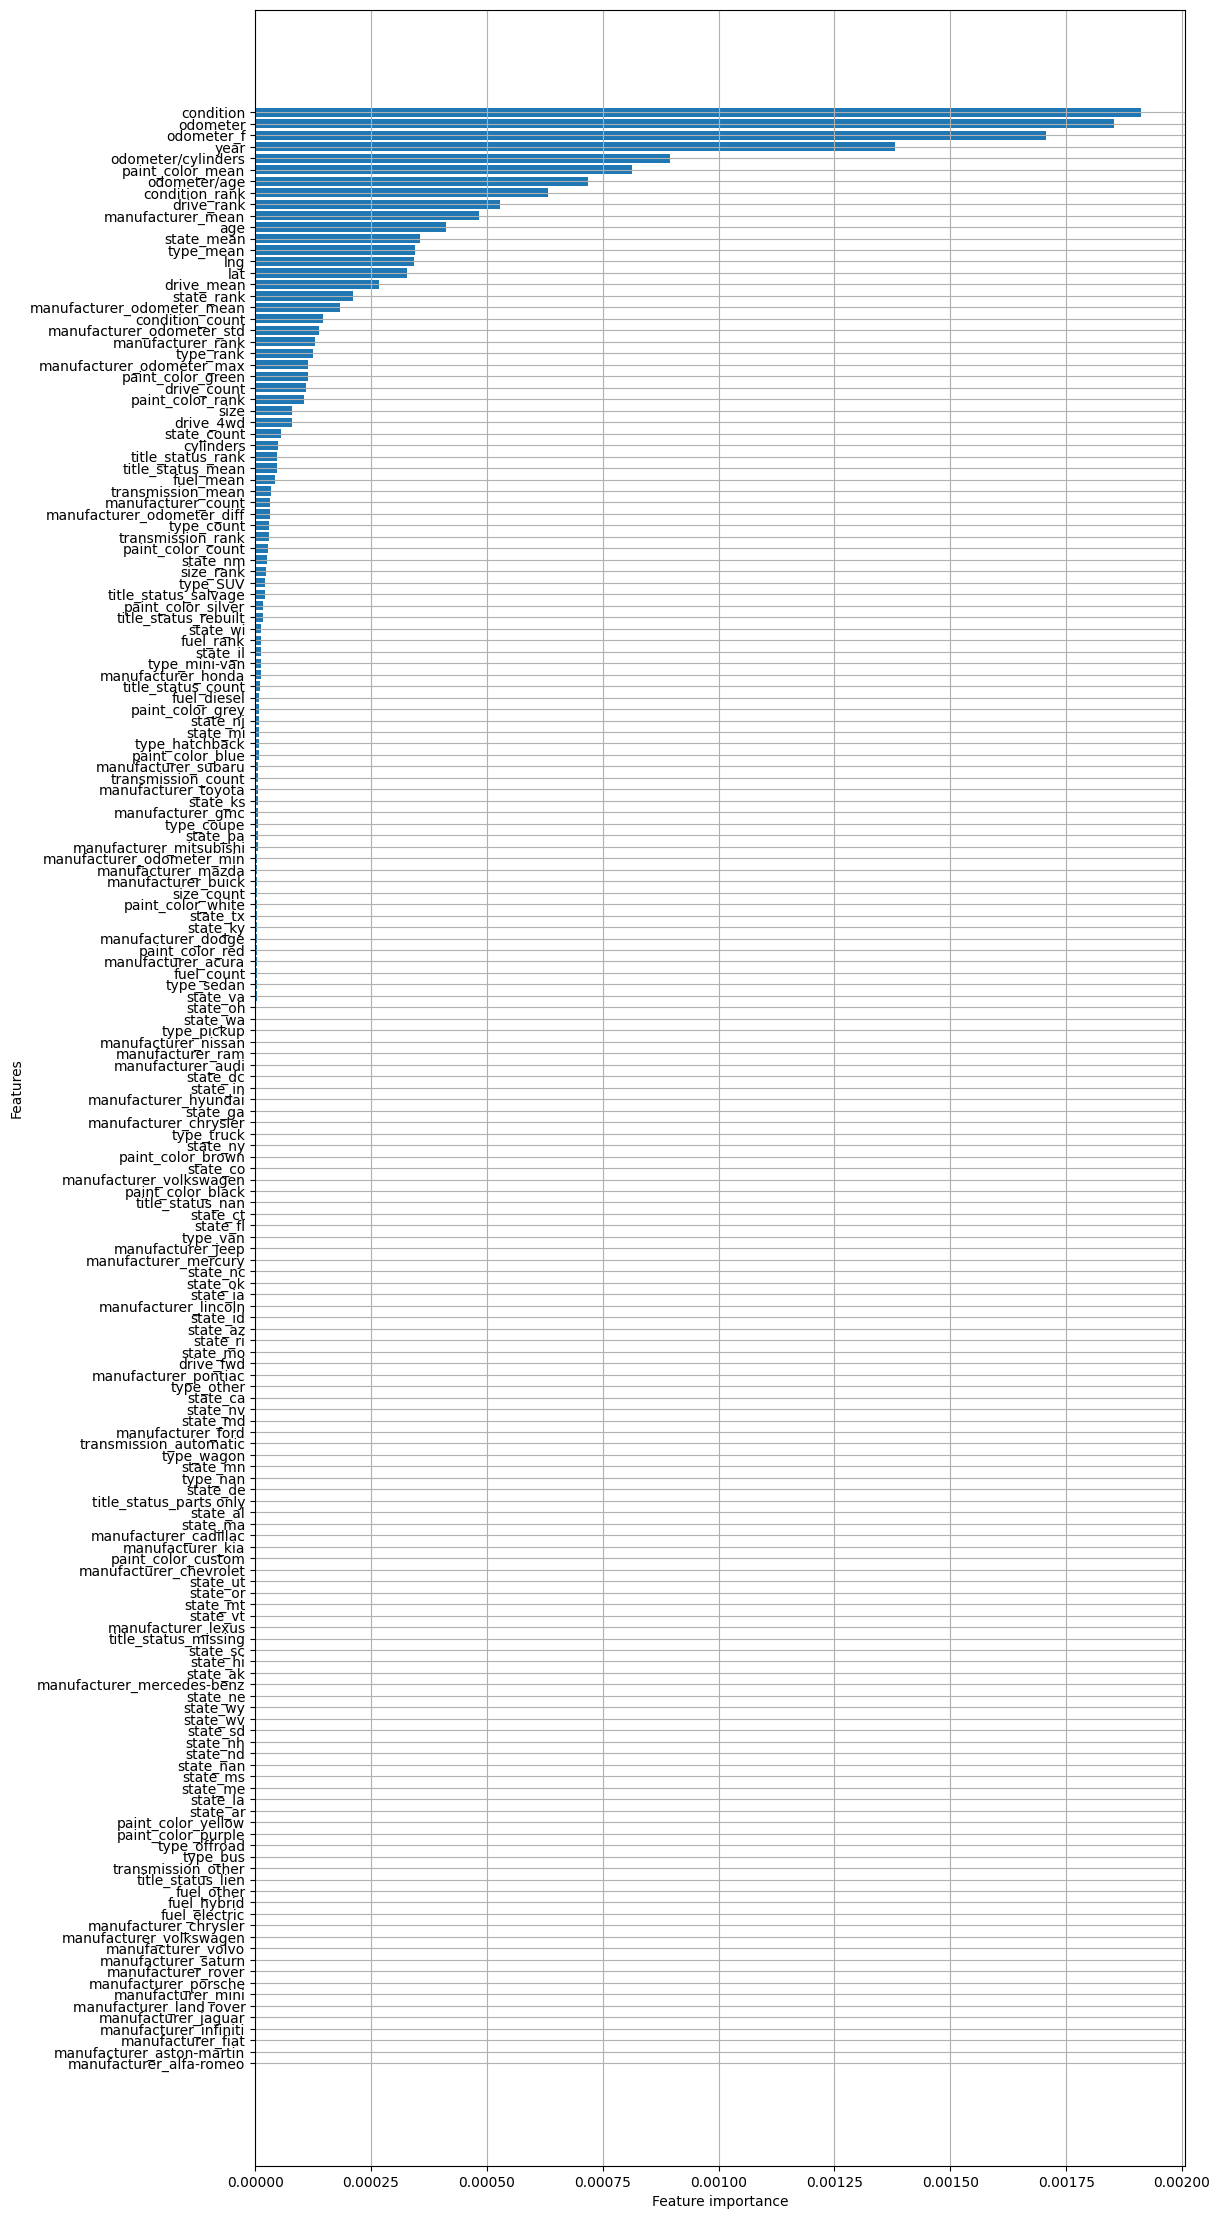

In [21]:
importance = lgbm.feature_importance()
importance = importance.sort(by='lgbm_importance_mean')
#グラフ表示
plt.figure(figsize=(12, 28))
plt.barh(importance['feature'], importance['lgbm_importance_mean'])
plt.xlabel('Feature importance')
plt.ylabel('Features')
plt.grid()
plt.show()

In [9]:
#xgb = XGBModel(train, test)
#xgb.objective(20)
#xgb.best_params = {'n_estimators': 767, 'max_depth': 8, 'lambda': 1.2306916748991704e-06, 'alpha': 0.018078104089246788, 'colsample_bytree': 0.42319770953022684, 'subsample': 0.2810517802368746, 'min_child_weight': 218, 'gamma': 6.031109467976734e-08, 'eta': 0.018889170085640027}
#xgb_predictions = xgb.predict()
#predictions = pl.concat([predictions, xgb_predictions], how="horizontal")

In [10]:
#rf = RandomForestModel(df)
##rf.objective(5)
#rf.best_params = {'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': 0.6306125661502896, 'max_leaf_nodes': 18, 'n_estimators': 8762, 'bootstrap': True}
#rf_predictions = rf.predict()
#predictions = pd.concat([predictions, rf_predictions], axis=1)

In [11]:
#rgf = RGFModel(df)
##rgf.objective(5)
#rgf.best_params = {'max_leaf': 8072, 'algorithm': 'RGF_Opt', 'test_interval': 142, 'min_samples_leaf': 11, 'reg_depth': 9, 'l2': 0.0002082492344277923, 'sl2': 4.2919223241162815e-07, 'normalize': False}
#rgf_predictions = rgf.predict()
#predictions = pd.concat([predictions, rgf_predictions], axis=1)

In [12]:
#cat = CatBoostModel(df)
##cat.objective(5)
#cat.best_params = {"depth": 6}
#cat_predictions = cat.predict()
#predictions = pd.concat([predictions, cat_predictions], axis=1)

In [13]:
predictions.head()

price,lgbm_pred_0,lgbm_pred_1,lgbm_pred_2,lgbm_pred_3,lgbm_pred_4
i64,f64,f64,f64,f64,f64
27587,6236.048201,6747.143035,6861.528211,6192.713373,6389.739574
4724,3549.565669,3637.804378,3358.65233,3867.904582,3448.900471
10931,3644.304528,3359.170709,3196.185517,3527.827986,3393.694743
16553,8367.05609,8746.299752,8854.941851,8469.381224,8850.200281
5158,4200.374701,4479.688733,4214.031052,4554.596491,4341.038013


In [14]:
#model = Ridge(random_state=0)
#train = predictions[predictions["price"].notnull()]
#test = predictions[predictions["price"].isnull()]
#X_train = train.drop(["price"], axis=1)
#y_train = train["price"]
#X_test = test.drop(["price"], axis=1)
#model.fit(X_train, y_train)
#y_pred = model.predict(X_test)

In [15]:
y_pred = lgbm_predictions.mean(axis=1)[train.height:].to_list()

In [16]:
#sub = pl.read_csv(os.path.join(os.path.dirname(__file__), "../input/submit_sample.csv"), has_header=False, new_columns=["id", "price"])
#sub = sub.with_columns(pl.Series("", y_pred).alias("price"))
#sub.write_csv(os.path.join(os.path.dirname(__file__), "../output/submission_te0810_3.csv"), has_header=False)